<a href="https://colab.research.google.com/github/leahshitindi/BigData-Science-Project/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deconvolution of bulk RNA-seq data

## Objective

The objective of the task was to use regression models to estimate the proportions of cell types present in a given sample. To accomplish this, single-cell RNA-seq data was utilized as input to estimate the cell type proportions within the bulk data in a given sample. The estimated proportions were then evaluated by comparing them with the true proportional data.
The task involved working with three datasets. The first dataset was the bulk cell counts, which represented gene expression levels across 100 samples. This dataset was used as the target variable for the regression models.
The second dataset was the single-cell counts, which provided gene expression levels for individual cells. This dataset served as the input for estimating the cell type proportions within the bulk data.
Lastly, the true proportion data was provided, containing the actual cell type proportions for each of the 100 samples. This true proportional data served as the ground truth for evaluating the performance of the regression models.
By training the regression models using the single-cell data and evaluating their estimated proportions against the true proportional data, the objective was to determine the accuracy and effectiveness of the models in estimating the cell type proportions within the bulk data.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy

In [3]:
# Import necessary packages


import scanpy as sc # convinient for single cell exploration
import pandas as pd # for reading dataframe
import numpy as np # for calculation
import matplotlib.pyplot as plt # for plotting 
import seaborn as sns # for visualization
from sklearn.decomposition import PCA # for dimension reductiion
from sklearn.preprocessing import StandardScaler # for data preprocessing
from sklearn.linear_model import Lasso, Ridge, LinearRegression # Linear regression Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # For model evaluation
from sklearn.metrics import mean_absolute_error # For model Evaluation\
from scipy.optimize import nnls
from time import time
%matplotlib inline


In [5]:
# Reading in all the data
path="/content/drive/MyDrive/Colab Notebooks/BigDataProject/"
singlecell_df =pd.read_csv(path+"singlecell_counts.tsv",sep="\t")
bulk_df = pd.read_csv(path+"bulk_counts.tsv",sep="\t")
trueprop_df= pd.read_csv(path+"true_proportions.tsv",sep="\t")



In [6]:
# identify genes with 0 total counts in single cell dataset
cell_counts=pd.DataFrame(singlecell_df.sum(axis=1)) # sum all the cell for each gene
cell_counts[0].name="n_cell_counts"
gene_by_cell=cell_counts.rename(columns={0:"cell_counts"})
gene_by_cell.sort_values("cell_counts") # sort to identify genes with 0 expression
zero_expression=gene_by_cell[gene_by_cell["cell_counts"]==0].index.tolist()


In [8]:
# identify genes with 0 cell counts in bulk data
zero_counts=bulk_df[bulk_df.sum(axis=1)<1].index.tolist()
zero_counts


['Eomes', 'Helt', 'Ncapg', 'Msx2']


## Initial data analysis

The initial data analysis involved idenfiying and removing genes with 0 expression,checking for data missingness, outlier detection and investigation of the distribution of different variables in the dataset.In the single cell data set 3 genes (Eomes', 'Helt', 'Ncapg')were identied and removed for having 0 cell total cell counts. The same genes had 0 total cell counts in bulk count data. In additional Msx2 gene was also found to have 0 expression in bulk count data hence it was removed in both dataset to ensure the same dimension of genes in both datasets.

Scatterplots and boxplots were utilized to identify cells with extreme total counts in the dataset. Upon analysis, three neuron4 cells were identified as outliers, as their total counts exceeded the 99th percentile of all cell total counts. However, these cells were not removed from the dataset because they exhibited outlying values not only in terms of total counts but also in the number of genes expressed. As a result, these outlier cells did not significantly impact the relationship between cell counts and the number of expressed genes.
In the scatter plot, a vertical line is included to indicate the cells that are far from all other cells.



In [11]:
# remove genes with 0 expression
sc_complete=singlecell_df.loc[~singlecell_df.index.isin(zero_counts)]
bulk_complete=bulk_df.loc[~bulk_df.index.isin(zero_counts)]


In [83]:
# create the dataset to exprore the genes expression for each cell 
sc_complete.T.sum(axis=1)
genes_counts=pd.DataFrame(singlecell_df.T.sum(axis=1))
genes_counts["n_genes_expressed"]=(sc_complete.T>=1).sum(axis=1) # counting number of genes
genes_counts=genes_counts.rename(columns={0:"total_counts"})
genes_counts=genes_counts[["total_counts","n_genes_expressed"]]
genes_counts['cell_type']=genes_counts.index.str.split("_").str[0]



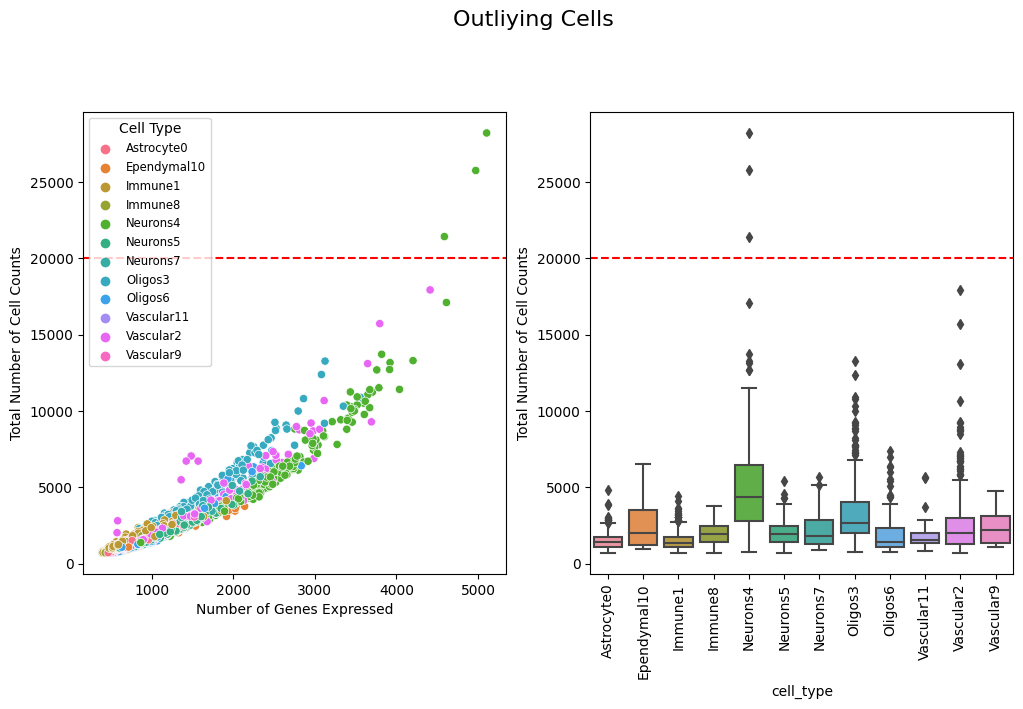

In [84]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 6))

# Scatterplot
sns.scatterplot(x="n_genes_expressed", y="total_counts", data=genes_counts, hue="cell_type", ax=ax1)
ax1.set_xlabel("Number of Genes Expressed")
ax1.set_ylabel("Total Number of Cell Counts")
ax1.axhline(y=20000, color='r', linestyle='--',)
ax1.legend(title="Cell Type", fontsize="small")
sns.boxplot(x="cell_type",y="total_counts",data=genes_counts,ax=ax2)
ax2.axhline(y=20000, color='r',linestyle='--')
ax2.set_ylabel("Total Number of Cell Counts")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
fig.suptitle("Outliying Cells", fontsize=16, y=1.05)  # Add the main title above the subplots
plt.show()



In [85]:
# create a dataframe to summarize number of gene expression in the sample
# create the dataset to exprore the genes expression for each cell 
bulk_complete.T.sum(axis=1)
total_cell=pd.DataFrame(bulk_complete.T.sum(axis=1))
total_cell["Number of Genes Expression"]=(bulk_complete.T>=1).sum(axis=1)
total_cell=total_cell.rename(columns={0:"total_cell"})
result = total_cell['Number of Genes Expression'].describe(exclude=['count', '25%', '75%'])[1:].round()
result_df=result.to_frame()
print(f"Summary Statistic of Number of Genes expression in the Sample\n")
result_df

Summary Statistic of Number of Genes expression in the Sample



,Number of Genes Expression
mean,10018.0
std,132.0
min,9530.0
25%,9940.0
50%,10040.0
75%,10113.0
max,10289.0


In [86]:
# create a dataframe to summarize number of gene expression in the sample
# create the dataset to exprore the genes expression for each cell 
cells=genes_counts.groupby('cell_type')
print('Summary statistic of number of genes expression for each cell type')
cells.agg({'n_genes_expressed': ['mean','min','max']})



Summary statistic of number of genes expression for each cell type


n_genes_expressed           
                         mean  min   max
cell_type                               
Astrocyte0         848.454175  451  1960
Ependymal10       1406.296296  711  2715
Immune1            743.455982  398  2119
Immune8            943.727273  432  1668
Neurons4          2180.326693  457  5106
Neurons5          1177.497382  547  2231
Neurons7          1092.189655  584  2332
Oligos3           1302.692754  438  3556
Oligos6           1085.715278  545  2835
Vascular11         999.592593  567  2267
Vascular2         1236.491841  493  4413
Vascular9         1195.814815  664  1910

## Dimension Reduction and clustering

To visualize and explore the single-cell data, we utilized the scanpy package, which is widely used in single-cell data analysis. This package provides convenient functionality for visualizing single-cell data. We employed three dimension reduction methods: UMAP, PCA, and t-SNE, to visualize the single-cell data. Figure 2 displays the t-sne plot generated from the single-cell data. Before performing the dimension reduction, we normalized the single cell data by deviding each cell count by total cell count and multiplying by 100000 and then standarzing by means and standard deviation

From the plot, we observed that cells of the same type exhibited high correlation, forming distinct clusters. This suggests that cells of the same type share similar gene expression patterns. Based on this finding, we can reduce the dimensionality of the data by aggregating cells of the same type into a single feature.

In [87]:
# Normalization and standardization
sc_normalized=sc_complete.applymap(np.log1p)
#sc_normalized=sc_complete/sc_complete.sum(axis=0)*10000
# Scaling
sc_scaled=(sc_normalized-sc_normalized.mean(axis=0))/sc_normalized.std(axis=0)


In [89]:
# convert a single cell data frame into AnnData object that support sc functionalities

sc_ann=sc.AnnData(sc_scaled.T)
sc_ann.obs["cell_type"]=sc_ann.obs.index.str.split("_").str[0]



In [90]:
# PCA
sc.tl.pca(sc_ann,svd_solver="arpack",n_comps=100) # calcualte the pca'sc

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


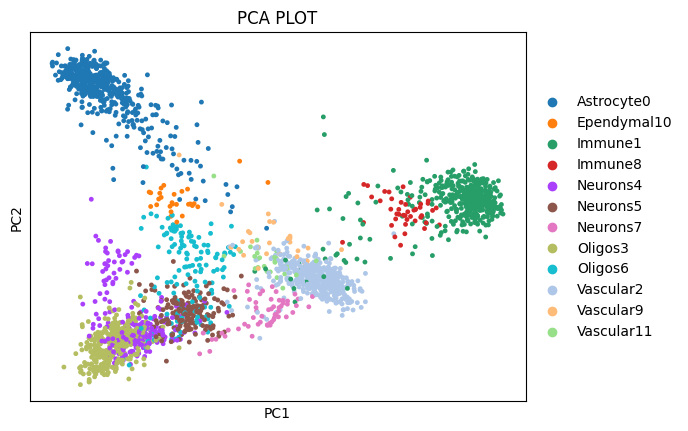

In [91]:
#pca plot
pca_plot=sc.pl.pca(sc_ann,color="cell_type",title="PCA PLOT")

In [95]:
#tsna
sc.tl.tsne(sc_ann,random_state=42)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


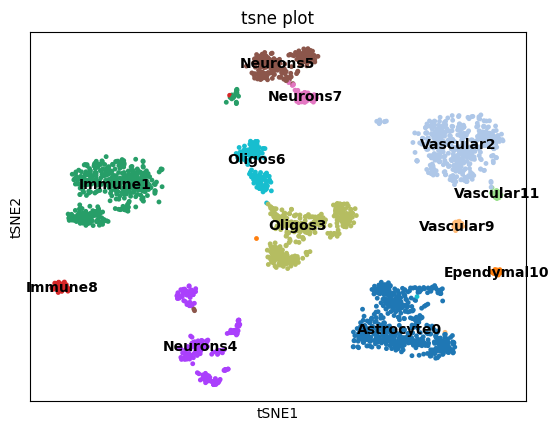

In [102]:
tsne_plot=sc.pl.tsne(sc_ann,color="cell_type",title="tsne plot",legend_loc='on data')

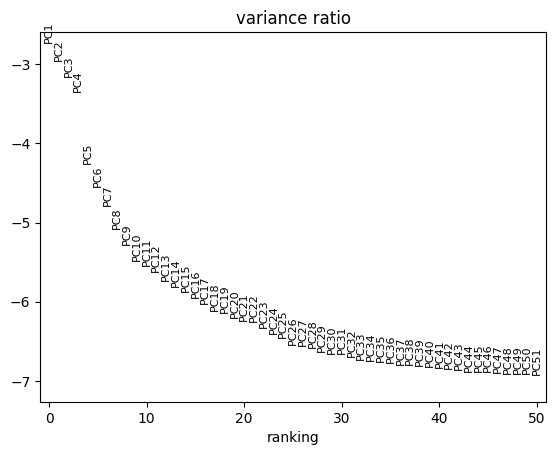

In [103]:
# Estimating the number of components that explain max variation
sc.pl.pca_variance_ratio(sc_ann, log=True,n_pcs=50)

In [104]:
# estimate the neigbbours
sc.pp.neighbors(sc_ann, n_pcs = 30,n_neighbors=10)

In [99]:
sc.tl.umap(sc_ann,random_state=112345)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


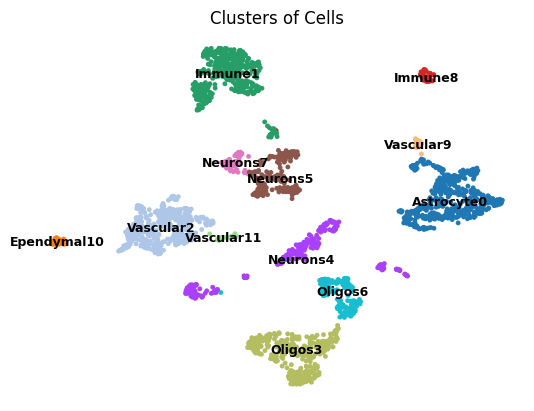

In [100]:
# plot with umap
sc.pl.umap(sc_ann, color='cell_type',\
           title='Clusters of Cells',
           legend_loc='on data',
           legend_fontsize=9,
           frameon=False)

## Statistical Analysis


## Model Training and Evaluation

1. <u>Model Training:</u>

Before training the regression model, the single-cell data and bulk count data underwent separate splitting into training and testing sets. The bulk cell data was split by sample, while the single-cell data was split by cell using stratified splitting based on cell type. This ensured proportional representation of cell types in both the training and testing sets. To prepare the single-cell data for regression modeling, the cells belonging to the same cell type were aggregated by taking the mean values, resulting in 12 features representing the average characteristics of each cell type. For models requiring hyperparameter optimization, such as Lasso and ridge regression, scikit-learn's LassoCV and ridgeCV models were employed. These models enable simultaneous optimization of hyperparameters during training, aiding in the selection of optimal hyperparameter values for improved model performance.
Four regression models, namely non-negative least squares, Ridge regression, Lasso, and Support Vector Regression (SVR), were trained using the training set. These models were then evaluated using the true proportional dataset, which serves as the ground truth for comparison and evaluation purposes. 

2. <u>Normalization of Coefficients:</u>

In order to satisfy the requirements of the cell proportional estimation, all parameters need to be positive and sum up to one. To ensure this, we implemented a normalization function called `normalizer`, which was used for all model parameters. This function guarantees that the parameters sum up to one. Additionally, for models that allow it, we set the `positive` argument to True to enforce all estimated parameters to be positive. In cases where the models did not have this argument, we set any negative parameters to zero.

3. <u>Model Evaluation:</u>

The performance of each regression model was evaluated by assessing how accurately it predicted the proportional values of the true dataset. Three metrics were used for this evaluation: Pearson correlation ($Cor(P, \hat{P})$), Absolute Mean Squared Deviation ($|P - \hat{P}|$), and Root Mean Squared Error ($\sqrt{P - \hat{P}}$). . These metrics allowed for quantifying the agreement between the true proportional values ($P$) and the model's estimated proportional values $\hat{P}$. A higher Pearson correlation indicates a stronger linear relationship between the true and estimated values, while lower values of Absolute Mean Squared Deviation and Root Mean Squared Error indicate better agreement between the true and estimated values.
To provide a visual representation of the model's performance, scatter plots were generated to illustrate how well the models predicted the true proportional values. These plots allow for a quick assessment of how closely the estimated values align with the true values.
Additionally, the training time for each model was recorded to compare their efficiency in terms of time. This information helps in understanding the computational efficiency of the regression models and can be considered along with the performance metrics for model selection.


## Results and Discussion

Each deconvolution method takes as input bulk expression profiles of mixed tissue samples and a reference molecular profile of the individual cell types, which are used to estimate the abundance of cell types in each sample. 

Bulk RNA-seq data contains a mixture of transcript signatures from several types of cells. We wish to deconvolve this mixture to obtain estimates of the proportions of cell types within the bulk sample. To do this, we can use single cell RNA-seq data as a reference for estimating the cell type proportions within the bulk data.

In [110]:
#data partitioning bulk data, we spli by sample size hence it is required to transpose the data before splitting
bulk_df=bulk_complete.T
bulk_train,bulk_test=train_test_split(bulk_df,test_size=0.2,random_state=123)
bulk_train=bulk_train.T
bulk_test=bulk_test.T


In [111]:
#transpose the sc to have cell in row for splitting
sc_t=sc_complete.T

# create a cell type variable for stratified splitting
cell_typ=sc_t.index.str.split("_").str[0]

# split sc by cell using cell type as stata
sc_train,sc_test=train_test_split(sc_t,train_size=0.8,random_state=123,stratify=cell_typ)

sc_train['cell_type']=sc_train.index.str.split('_').str[0]
sc_test['cell_type']=sc_test.index.str.split('_').str[0]

# the whole dataset
sc_t["cell_type"]=sc_t.index.str.split('_').str[0]


In [112]:
# aggregate the cell type by their means
sc_mean_train=sc_train.groupby('cell_type').mean().T
sc_mean_test=sc_test.groupby('cell_type').mean().T
sc_df=sc_t.groupby("cell_type").mean().T


In [113]:

# subset the true proportinal data for evaluation they should contain the same 
#sample as the training set. This set will be used for evaluation

in_train=trueprop_df.loc[bulk_train.columns.tolist()]
in_test=trueprop_df.loc[bulk_test.columns.tolist()]

# just making thinng convinient by using simple names
train_X,train_y,test_X,test_y = sc_mean_train,bulk_train,sc_mean_test,bulk_test
sc_full,bulk_full=sc_df,bulk_df.T

In [114]:
# create a normalization function
def normalize_coef(row):
    return row / row.sum()

# create a visualization function
def visualize(true_props, est, correlation,mse,mad,elapsed=0,title="Model Title",subtitle="Model"):
    plt.scatter(true_props.values.flatten(), est.values.flatten())
# Add labels to the x-axis and y-axis
    plt.xlabel('True propotions')
    plt.ylabel('Estimated proportions')
    plt.text(true_props.values.min(), est.values.max(), f"Correlation: {correlation:.2f}", ha='left', va='top')
    plt.text(true_props.values.min(), est.values.max()-0.02, f"MSE: {mse:.4f}", ha='left', va='top')
    plt.text(true_props.values.min(), est.values.max()-0.04, f"MAD: {mad:.2f}", ha='left', va='top')
    plt.text(true_props.values.min(), est.values.max()-0.06, f"run time: {elapsed:.2f}", ha='left', va='top')
    plt.title(title)
    plt.suptitle(subtitle,y=1)
    plt.show()
title="Correlation between the True cell Proportion and\n Estimated Cell Proportions by Ridge Regression"


In [115]:
# Linear regression function
def ols(predictor,response,true_props):
    
    # Train the model
    start_ols=  time()
    model=LinearRegression(positive=True) 
    model.fit(predictor,response)
    end_ols=time()
    elapsed_ols=end_ols-start_ols


    # Obtain the coeficient and create a data frame of coefficient

    betas=pd.DataFrame(model.coef_,columns=model.feature_names_in_.tolist(),index=response.columns.tolist())

    # Normalize all coefficient to sum into 1 
    betas=betas.apply(normalize_coef,axis=1)

    # Model Evaluation
    mean_corr_ols=betas.corrwith(true_props).mean() # Pearson correlation

    mse_ols=mean_squared_error(true_props,betas) # mean squared error


    MAD_ols= mean_absolute_error(true_props, betas) # Absolute mean squared deviation
    #Visualize the model performance

    title="Correlation between True cell Proportion and\n Estimated Cell Proportions"
    visualize(true_props,betas,mean_corr_ols,MAD_ols,elapsed_ols,title=title)
    return f"Correlation:{mean_corr_ols}",f"MSE:{mse_ols}",f"MAD:{MAD_ols}", f"run time:{elapsed_ols}"

In [116]:
# Ridge model with cross validation algorithm function

from sklearn.linear_model import RidgeCV
def ridge(predictor,response,true_props,subtitle):
    # model training
    start_rigde=time()
    clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1],store_cv_values=True,fit_intercept=False\
                ).fit(predictor, response)
    end_ridge= time()

    # Model run time
    elapsed_ridge= end_ridge-start_rigde

    # Obtain the model coefficients into a data frame
    betas_clf=pd.DataFrame(clf.coef_,columns=clf.feature_names_in_.tolist(),index=response.columns.tolist())

    # Normalize coefficients
    prop_betas=betas_clf.applymap(lambda x: 0 if x< 0 else x)
    prop_betas = prop_betas.apply(normalize_coef,axis=1)

    # Evaluation
    corr_ridge=prop_betas.corrwith(true_props).mean()
    MSE_ridge=mean_squared_error(prop_betas,true_props)
    mad_ridge=mean_absolute_error(true_props,prop_betas)

    title="Correlation between True cell Proportion and\n Estimated Cell Proportions"
    # Visualization
    visualize(true_props,prop_betas,corr_ridge,MSE_ridge,mad_ridge,elapsed_ridge, title=title,subtitle=subtitle)
    return f"Correlation: {corr_ridge}",f"MSE:{MSE_ridge}",f"MAD:{mad_ridge}",f"run time:{elapsed_ridge}"


In [117]:
# Support vector Regression Model function

from sklearn import svm
def svr(predictor,response,true_props,subtitle):

    start_time= time()

    models = []
    for i in range(response.shape[1]):
        regr = svm.SVR(kernel="linear")
        regr.fit(predictor, response.iloc[:, i])  # Fit SVR model for the i-th column
        models.append(regr)

    end_time= time()
    svr_elapsed=end_time-start_time

    # Extracting the results from the list of model coeff
    svr_betas=pd.DataFrame(columns=true_props.columns)
    betas_dict=dict()
    indeces=response.columns
    for i, index in enumerate(indeces):
        data = pd.DataFrame(models[i].coef_,columns=true_props.columns,index=[index])
        svr_betas=pd.concat([svr_betas,data],axis=0)
    svr_betas_positive=svr_betas.applymap(lambda x:0 if x<0 else x)
    svr_betas_positive=svr_betas_positive.apply(normalize_coef,axis=1)
    correlation = svr_betas_positive.corrwith(true_props).mean()
    MAD=mean_absolute_error(svr_betas_positive,true_props)
    print(f"mean squares absolute deviation is {MAD:.3F}")
    MSE=mean_squared_error(svr_betas_positive,true_props)
    print(f"mean squared error for svr is {MSE:.5f}")

    # Visualization
    title="Correlation between True cell Proportions and Estimated Cell Proportions"
    visualize(true_props,svr_betas_positive,correlation,MSE,MAD,elapsed=svr_elapsed,title=title,subtitle=subtitle)
    return f"correlation: {correlation}",f"MSE:{MSE}",f"MAD:{MAD}",f"run time:{svr_elapsed}"
    

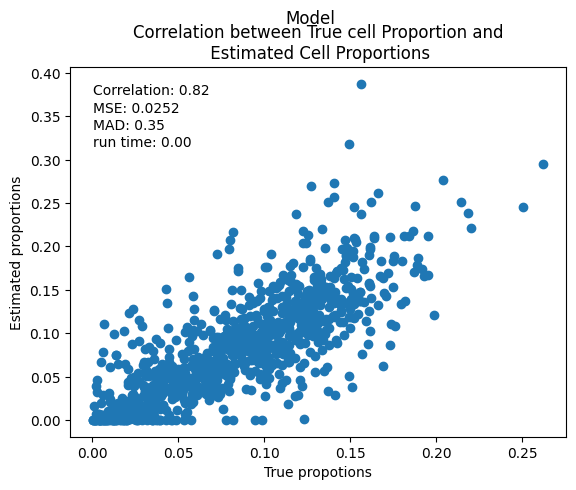

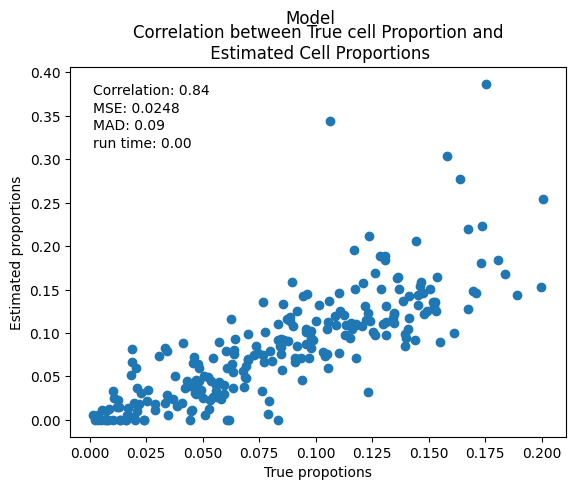

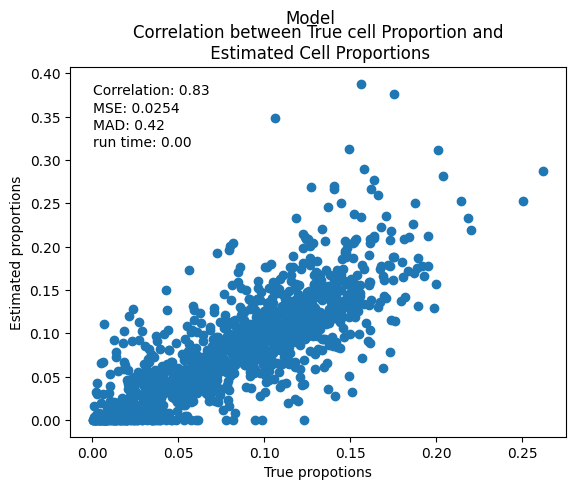

In [118]:
## regression models
#1 on training data
ols_train=ols(train_X,train_y,in_train)
ols_corr=ols_train[0].split(":")[1].replace(" ","")
ols_mse=ols_train[1].split(":")[1]
ols_mad=ols_train[2].split(":")[1]
ols_time=ols_train[3].split(":")[1]

#2 on test data
ols_test=ols(test_X,test_y,in_test)
ols_corr_test=ols_test[0].split(":")[1]
ols_mse_test=ols_test[1].split(":")[1]
ols_mad_test=ols_test[2].split(":")[1]
ols_time_test=ols_test[3].split(":")[1]

#3 on full data
ols_full=ols(sc_full,bulk_full,trueprop_df)
ols_corr_ful=ols_full[0].split(":")[1]
ols_mse_full=ols_full[1].split(":")[1]
ols_mad_full=ols_full[2].split(":")[1]
ols_time_full=ols_full[3].split(":")[1]



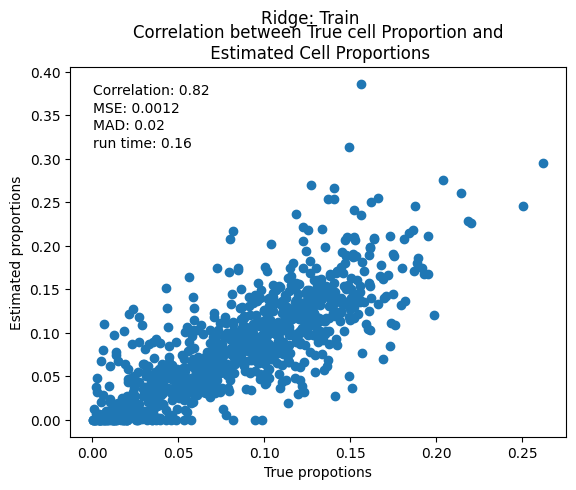

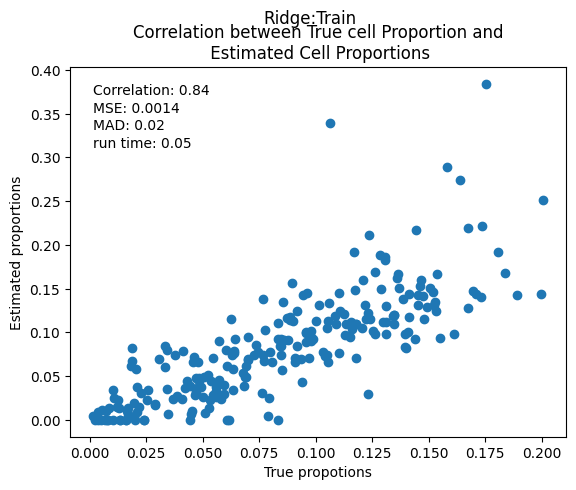

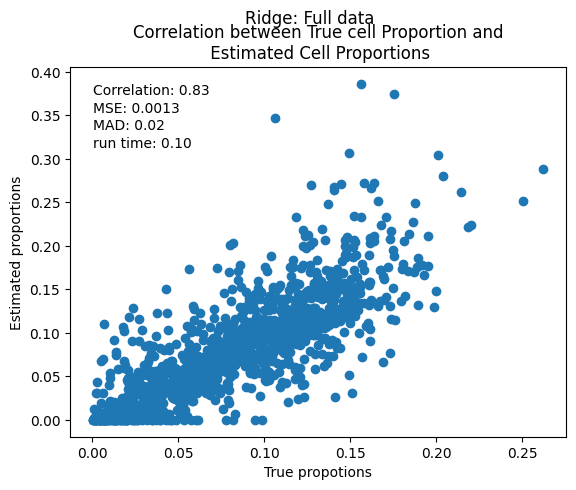

In [119]:
# regression models
#1 on training data
ridge_train=ridge(train_X,train_y,in_train,"Ridge: Train")
ridge_corr=ridge_train[0].split(":")[1].replace(" ","")
ridge_mse=ridge_train[1].split(":")[1]
ridge_mad=ridge_train[2].split(":")[1]
ridge_time=ridge_train[3].split(":")[1]

# #2 on test data
ridge_test=ridge(test_X,test_y,in_test,"Ridge:Test")
ridge_corr_test=ridge_test[0].split(":")[1].replace(" ","")
ridge_mse_test=ridge_test[1].split(":")[1]
ridge_mad_test=ridge_test[2].split(":")[1]
ridge_time_test=ridge_test[3].split(":")[1]

#3 on full data
ridge_full=ridge(sc_full,bulk_full,trueprop_df,"Ridge: Full data")
ridge_corr_ful=ridge_full[0].split(":")[1]
ridge_mse_full=ridge_full[1].split(":")[1]
ridge_mad_full=ridge_full[2].split(":")[1]
ridge_time_full=ridge_full[3].split(":")[1]


mean squares absolute deviation is 0.017
mean squared error for svr is 0.00051


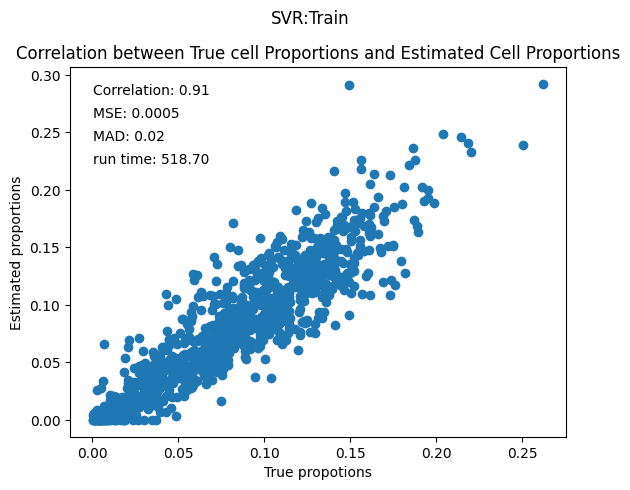

mean squares absolute deviation is 0.019
mean squared error for svr is 0.00060


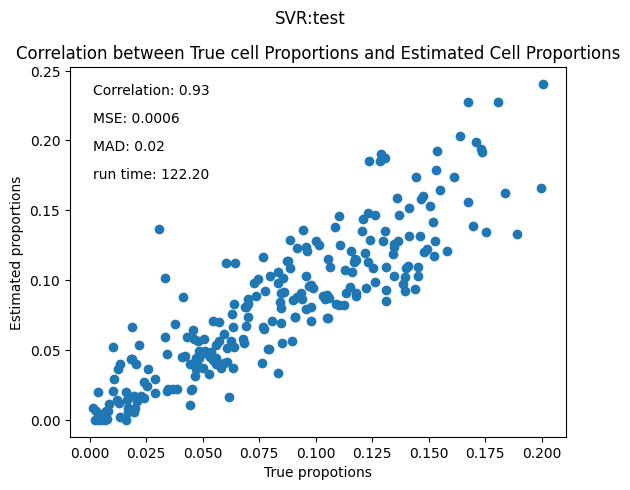

mean squares absolute deviation is 0.017
mean squared error for svr is 0.00049


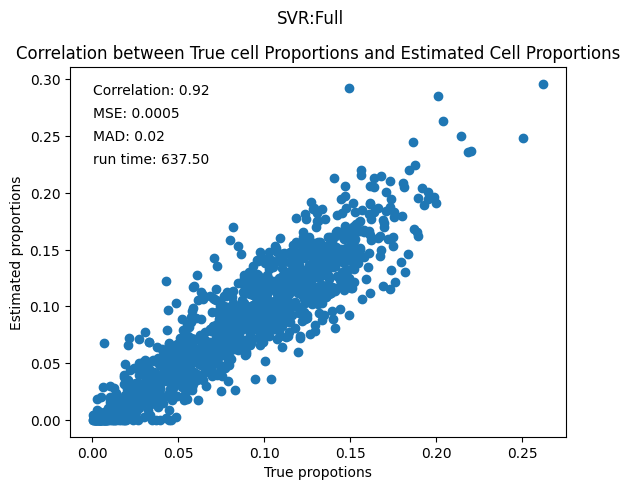

In [120]:
# regression models
#1 on training data
svr_train=svr(train_X,train_y,in_train,subtitle="SVR:Train")
svr_corr=svr_train[0].split(":")[1]
svr_mse=svr_train[1].split(":")[1]
svr_mad=svr_train[2].split(":")[1]
svr_time=svr_train[3].split(":")[1]

# #2 on test data
svr_test=svr(test_X,test_y,in_test,subtitle="SVR:test")
svr_corr_test=svr_test[0].split(":")[1]
svr_mse_test=svr_test[1].split(":")[1]
svr_mad_test=svr_test[2].split(":")[1]
svr_time_test=svr_test[3].split(":")[1]

#3 on full data
svr_full=svr(sc_full,bulk_full,trueprop_df,subtitle="SVR:Full")
svr_corr_ful=svr_full[0].split(":")[1]
svr_mse_full=svr_full[1].split(":")[1]
svr_mad_full=svr_full[2].split(":")[1]
svr_time_full=svr_full[3].split(":")[1]

,Metrics,Ridge,LRM,SVR
0,Correlation,0.824550,0.820090,0.912574
1,MAD,0.024625,0.025198,0.016901
2,Run_time,0.160246,0.347629,518.700101


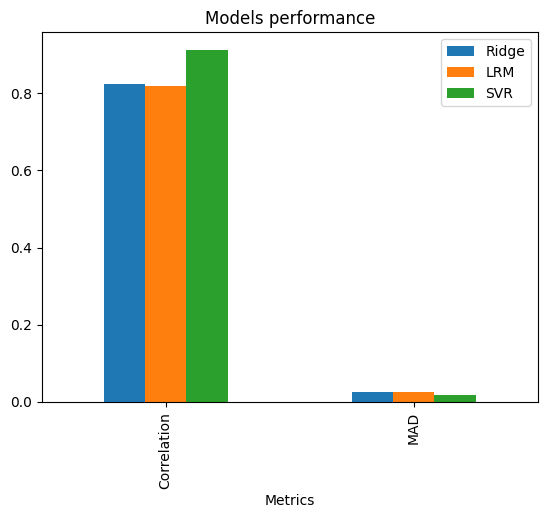

In [121]:


data2={"Metrics":["Correlation","MAD","Run_time"],
      "Ridge":[float(ridge_corr),float(ridge_mad),float(ridge_time)],
      'LRM':[float(ols_corr),float(ols_mad),float(ols_time)],
      'SVR':[float(svr_corr),float(svr_mad),float(svr_time)]}
df2=pd.DataFrame(data2)
df2.iloc[0:-1,:].plot.bar(x="Metrics",title="Models performance")
df2


## Results and Discussion
In this study, three models, namely Linear Regression, Ridge Regression, and Support Vector Regression (SVR), were trained to estimate the proportional cell types in a sample of bulk data. The models were evaluated based on their accuracy in predicting the true cell type proportions.  The evaluation metrics used were correlation, mean absolute deviation (MAD), and model training run time. Based on the results, all three models achieved relatively high correlation values, indicating a strong linear relationship between the estimated and true cell type proportions. SVR outperformed the other models with the highest correlation value of (0.912), followed closely by Ridge (0.831) and LRM (0.827). However, it's worth noting that SVR had a significantly longer run time (452.61) compared to the other models, with Ridge (0.073) and LRM (0.352) performing considerably faster. This can be attributed to the fact that SVR does not support multitask model training, requiring the model to be trained individually for each sample in a loop. As a result, the SVR model had to go through the entire sample, leading to a longer overall training time. 

Overall, the results indicate that the SVR model outperformed the other models in terms of accuracy, albeit at the cost of increased training time. These findings suggest that the SVR model may be a suitable choice for estimating cell type proportions in bulk data samples, particularly when accuracy is of primary importance. However, considering the longer training time, it is important to weigh the trade-off between accuracy and computational efficiency when selecting the appropriate model for the specific requirements of the study.

